In [ ]:
import numpy as np
import matplotlib.pylab as plt

In [ ]:
# Global Variables
__input_file__ = "dataset.txt"
__context_size__ = 100
__arm_size__ = 10

In [ ]:
# Function to calculate the Cummulative Take Rate
def calc_CTR(reward, ctr_num, ctr_den):

    # Keeps a count of CTR and updates the numerator and denominator on every correct call
    ctr_num = ctr_num + reward
    ctr_den = ctr_den + 1

    ctr = ctr_num/ctr_den

    return ctr, ctr_num, ctr_den

In [ ]:
# linUCB Algorithm
def linUCB(data, __alpha__):

    # Dictionary to store CTR at every time step
    CTR = {}

    # Declare the coefficient, upper confidence bound dictionary and the other dictionaries
    # used for plotting the various graphs
    coeff = {}
    ucb = {}
    ucb_mean = {}
    arm_pred = {}
    correct_pred = {}

    # Declare dictionaries A and b
    A = {}
    b = {}
    for arm in range(1,__arm_size__ + 1):
        # Initialize matrix A and b for each arm, with dimension as 100 which is the size of context
        A[arm] = np.identity(__context_size__)    # dimension 100 * 100
        b[arm] = np.atleast_2d(np.zeros(__context_size__)).T # dimension 100 * 1

        # Initialize UCBs as 0 for all arms
        ucb[arm] = 0

        # Initialize arm prediction for each arm - to plot it later
        arm_pred[arm] = 0
        correct_pred[arm] = 0
        ucb_mean[arm] = 0

    # Initiate time, predicted arm and numerator and denominators of CTR
    time = 1
    ctr_num = 0
    ctr_den = 0

    # Iterate over all 10,000 data point
    for line in data:

        # Fetch individual values to perform operations on them
        values = line.split()

        # Convert all strings in the list to integer
        values = list(map(int, values))

        # Get the Arm - which is the action performed
        curr_arm = values.pop(0)

        # Get reward for the current action
        reward = values.pop(0)

        # Create the context array
        context = np.asarray(values)

        # Loop to update coefficient and calculate pay off for each arm
        for arm in range(1,__arm_size__ + 1):
            # Calculate the coefficent, standard deviation and UCB for the arm
            coeff[arm] = np.dot(np.linalg.inv(A[arm]), b[arm])
            standard_deviation = np.sqrt(np.dot(context.T, np.dot(np.linalg.inv(A[arm]), context)))

            # Method 1 - Prediction count dependent alpha
            if(__alpha__ == -1):
                denom = 0.001/((correct_pred[arm]+1)/10)
                ucb[arm] = np.asscalar(np.dot(coeff[arm].T, context) + np.dot(denom, standard_deviation))
            elif(__alpha__ == 0):
                # Method 2 - Time Dependent Alpha
                ucb[arm] = np.asscalar(np.dot(coeff[arm].T, context) + np.dot((1/time**0.5), standard_deviation))
            else:
                # Method 3 - Constant Alpha
                ucb[arm] = np.asscalar(np.dot(coeff[arm].T, context) + np.dot(__alpha__, standard_deviation))

            ucb_mean[arm] += ucb[arm]

        # Choose the arm with largest UCB
        pred_arm = np.argmax(list(ucb.values())) + 1

        # Count of Predicted Arm
        arm_pred[curr_arm] += 1
        # If the prediction matches the current arm, calculate CTR and update values
        if(curr_arm == pred_arm):
            # Update matrix A and B
            A[curr_arm] = A[curr_arm] + np.outer(context, context)
            b[curr_arm] = b[curr_arm] + reward * np.reshape(context,(100,1))
            # Call calculate CTR function
            curr_CTR, ctr_num, ctr_den = calc_CTR(reward, ctr_num, ctr_den)
            # Store the CTR at current time stamp
            CTR[time] = curr_CTR
            correct_pred[curr_arm] += 1


        # Increment the time step
        time += 1
    return CTR

In [ ]:
# linUCB Algorithm
def divlinUCB(data, __alpha__, beta):
    T_v=0
    # Dictionary to store CTR at every time step
    CTR = {}

    # Declare the coefficient, upper confidence bound dictionary and the other dictionaries
    # used for plotting the various graphs
    coeff = {}
    ucb = {}
    ucb_mean = {}
    arm_pred = {}
    correct_pred = {}

    # Declare dictionaries A and b
    A = {}
    b = {}
    r_c ={}
    for arm in range(1,__arm_size__ + 1):
        # Initialize matrix A and b for each arm, with dimension as 100 which is the size of context
        A[arm] = np.identity(__context_size__)    # dimension 100 * 100
        b[arm] = np.atleast_2d(np.zeros(__context_size__)).T # dimension 100 * 1
        # Intitialize recomendation count
        r_c[arm] = 0
        # Initialize UCBs as 0 for all arms
        ucb[arm] = 0

        # Initialize arm prediction for each arm - to plot it later
        arm_pred[arm] = 0
        correct_pred[arm] = 0
        ucb_mean[arm] = 0

    # Initiate time, predicted arm and numerator and denominators of CTR
    time = 1
    ctr_num = 0
    ctr_den = 0

    # Iterate over all 10,000 data point
    for line in data:

        # Fetch individual values to perform operations on them
        values = line.split()

        # Convert all strings in the list to integer
        values = list(map(int, values))

        # Get the Arm - which is the action performed
        curr_arm = values.pop(0)

        # Get reward for the current action
        reward = values.pop(0)

        # Create the context array
        context = np.asarray(values)

        # Loop to update coefficient and calculate pay off for each arm
        for arm in range(1,__arm_size__ + 1):
            # Calculate the coefficent, standard deviation and UCB for the arm
            coeff[arm] = np.dot(np.linalg.inv(A[arm]), b[arm])
            standard_deviation = np.sqrt(np.dot(context.T, np.dot(np.linalg.inv(A[arm]), context)))
            if T_v==0:
              if(__alpha__ == -1):
                  denom = 0.001/((correct_pred[arm]+1)/10)
                  ucb[arm] = (np.asscalar(np.dot(coeff[arm].T, context))/(1+beta) + np.dot(denom, standard_deviation))
              elif(__alpha__ == 0):
                  # Method 2 - Time Dependent Alpha
                  ucb[arm] = (np.asscalar(np.dot(coeff[arm].T, context))/(1+beta) + np.dot((1/time**0.5), standard_deviation))
              else:
                  # Method 3 - Constant Alpha
                  ucb[arm] = (np.asscalar(np.dot(coeff[arm].T, context))/(1+beta) + np.dot(__alpha__, standard_deviation))              
              ucb_mean[arm] += ucb[arm]
            else:
              # Method 1 - Prediction count dependent alpha
              if(__alpha__ == -1):
                  denom = 0.001/((correct_pred[arm]+1)/10)
                  ucb[arm] = (np.asscalar(np.dot(coeff[arm].T, context))/(1+(beta*(r_c[arm]/T_v)**2)) + np.dot(denom, standard_deviation))
              elif(__alpha__ == 0):
                  # Method 2 - Time Dependent Alpha
                  ucb[arm] = (np.asscalar(np.dot(coeff[arm].T, context))/(1+(beta*(r_c[arm]/T_v)**2)) + np.dot((1/time**0.5), standard_deviation))
              else:
                  # Method 3 - Constant Alpha
                  ucb[arm] = (np.asscalar(np.dot(coeff[arm].T, context))/(1+(beta*(r_c[arm]/T_v)**2)) + np.dot(__alpha__, standard_deviation))

              ucb_mean[arm] += ucb[arm]

        # Choose the arm with largest UCB
        pred_arm = np.argmax(list(ucb.values())) + 1

        # Count of Predicted Arm
        arm_pred[curr_arm] += 1

        # If the prediction matches the current arm, calculate CTR and update values
        if(curr_arm == pred_arm):
            # Update matrix A and B
            T_v += 1
            r_c[arm] += 1
            A[curr_arm] = A[curr_arm] + np.outer(context, context)
            b[curr_arm] = b[curr_arm] + reward * np.reshape(context,(100,1))
            # Call calculate CTR function
            curr_CTR, ctr_num, ctr_den = calc_CTR(reward, ctr_num, ctr_den)
            # Store the CTR at current time stamp
            CTR[time] = curr_CTR
            correct_pred[curr_arm] += 1


        # Increment the time step
        time += 1
    return CTR

In [ ]:
# Function to plot the combined CTR graphs
def plotCTR(CTR, CTR1, CTR2, CTR3):

    lists = sorted(CTR.items())
    x, y = zip(*lists) # unpack a list of pairs into two tuples

    lists = sorted(CTR1.items())
    x1, y1 = zip(*lists)

    lists = sorted(CTR2.items())
    x2, y2 = zip(*lists)

    lists = sorted(CTR3.items())
    x3, y3 = zip(*lists)

    p1 = plt.plot(x, y, label = 'alpha = 0.001', color = 'b')
    p2 = plt.plot(x1, y1, label = 'alpha = 1', color = 'r')
    p3 = plt.plot(x2, y2, label = 'alpha = 1/sqrt(t)', color = 'g')
    p4 = plt.plot(x3, y3, label = 'alpha = 0.001/(0.1*Prediction Count)', color = 'm')

    ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)
    ax.set_xlabel('X axis (time steps) ->')
    ax.set_ylabel('Y axis (CTR) ->')
    ax.set_title('Contextual Bandit Learning for Different alpha values')
    ax.grid(True, linestyle='-.')
    ax.set_yticks(np.arange(0, 1, 0.1))
    plt.show()

In [ ]:
# Function to plot the combined CTR graphs
def plotCTR2(CTR, CTR1, CTR2, CTR3):

    lists = sorted(CTR.items())
    x, y = zip(*lists) # unpack a list of pairs into two tuples

    lists = sorted(CTR1.items())
    x1, y1 = zip(*lists)

    lists = sorted(CTR2.items())
    x2, y2 = zip(*lists)

    lists = sorted(CTR3.items())
    x3, y3 = zip(*lists)

    p1 = plt.plot(x, y, label = 'beta = 0', color = 'b')
    p2 = plt.plot(x1, y1, label = 'beta = 0.1', color = 'r')
    p3 = plt.plot(x2, y2, label = 'beta = 10', color = 'g')
    p4 = plt.plot(x3, y3, label = 'beta = 1000', color = 'm')

    ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)
    ax.set_xlabel('X axis (time steps) ->')
    ax.set_ylabel('Y axis (CTR) ->')
    ax.set_title('Contextual Bandit Learning for Different beta values')
    ax.grid(True, linestyle='-.')
    ax.set_yticks(np.arange(0, 1, 0.1))
    plt.show()

In [ ]:
    with open(__input_file__,"r") as file:
        # Strip the new line character from the end of each line
        data = [line.strip("\n") for line in file]

----------------------------------------------------------------------------------------------------------
Results: When Applied LinUCB:
----------------------------------------------------------------------------------------------------------




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


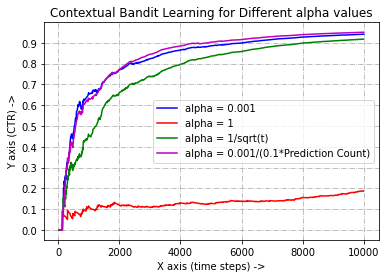

In [ ]:
# Main driver function
print('----------------------------------------------------------------------------------------------------------')
print('Results: When Applied LinUCB:')
print('----------------------------------------------------------------------------------------------------------')
print('\n')
if __name__ == "__main__":

    # Fetch the data from the file
    with open(__input_file__,"r") as file:
        # Strip the new line character from the end of each line
        data = [line.strip("\n") for line in file]

    # Call linUCB Algorithm for different alpha values
    CTR = linUCB(data, 0.001)
    CTR1 = linUCB(data, 1)
    # 0 and -1 alpha values here just hand the time and arm dependent cases
    CTR2 = linUCB(data, 0)
    CTR3 = linUCB(data, -1)

    #  ********** Plot the combined CTR Graphs **********
    plotCTR(CTR, CTR1, CTR2, CTR3)

----------------------------------------------------------------------------------------------------------
Results: When Applied DivLinUCB with different values of alpha:
----------------------------------------------------------------------------------------------------------




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


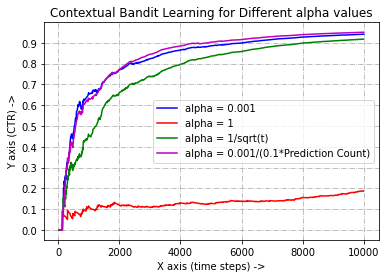

In [ ]:
# Main driver function
print('----------------------------------------------------------------------------------------------------------')
print('Results: When Applied DivLinUCB with different values of alpha:')
print('----------------------------------------------------------------------------------------------------------')
print('\n')
if __name__ == "__main__":

    # Fetch the data from the file
    with open(__input_file__,"r") as file:
        # Strip the new line character from the end of each line
        data = [line.strip("\n") for line in file]

    # Call linUCB Algorithm for different alpha values
    CTR = divlinUCB(data, 0.001, 0.01)
    CTR1 = divlinUCB(data, 1, 0.01)
    # 0 and -1 alpha values here just hand the time and arm dependent cases
    CTR2 = divlinUCB(data, 0, 0.01)
    CTR3 = divlinUCB(data, -1, 0.01)

    #  ********** Plot the combined CTR Graphs **********
    plotCTR(CTR, CTR1, CTR2, CTR3)

----------------------------------------------------------------------------------------------------------
Results: When Applied DivLinUCB with different values of beta:
----------------------------------------------------------------------------------------------------------




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


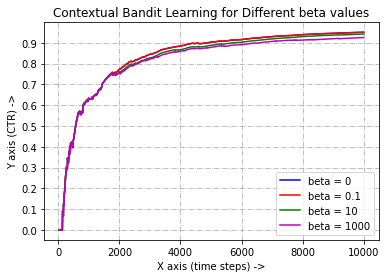

In [ ]:
# Main driver function
print('----------------------------------------------------------------------------------------------------------')
print('Results: When Applied DivLinUCB with different values of beta:')
print('----------------------------------------------------------------------------------------------------------')
print('\n')
if __name__ == "__main__":

    # Fetch the data from the file
    with open(__input_file__,"r") as file:
        # Strip the new line character from the end of each line
        data = [line.strip("\n") for line in file]

    # Call linUCB Algorithm for different alpha values
    CTR = divlinUCB(data, -1, 0)
    CTR1 = divlinUCB(data, -1, 0.1)
    # 0 and -1 alpha values here just hand the time and arm dependent cases
    CTR2 = divlinUCB(data, -1, 10)
    CTR3 = divlinUCB(data, -1, 1000)

    #  ********** Plot the combined CTR Graphs **********
    plotCTR2(CTR, CTR1, CTR2, CTR3)